<a href="https://colab.research.google.com/github/MThwa/crypto-analytics/blob/main/dungeonsPlayedTogether.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.auth import default
from datetime import datetime
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# get big query access
credentials, project = default()
client = bigquery.Client(credentials=credentials, project=project)

In [ ]:
# get usernames
users = client.query('''
  select
  to_hex(sha256(id)) user_id,
  username
  from openloot-362008.postgres_rds_auth_api_public.users
''').to_dataframe()

# get dungeon table
df = client.query('''
  select
  *
  from bigtimestudios.PlayerAnalytics.total_dungeons_data
  where event_date > date_sub(current_date(), interval 21 day)
''').to_dataframe()

df['event_date'] = pd.to_datetime(df['event_date'])

,total_users_in_dungeon,event_date,DungeonInstanceGUID,first_done,DungeonDuration,PortalType,TileSet,Mission,TotalOpenLoot_TimeCrystals,Default__GA_Player_SpawnTreeOfLife_C,...,TotalOpenLoot_PristineMaterial_Halloween2024_Pumpkin,TotalRevives,PlayerRoll_01,PlayerRoll_02,PlayerRoll_03,PlayerRoll_04,PlayerRoll_05,PlayerRoll_06,completion_status,boss_chest_opens
0,0,2025-10-06,7FF489C96AEA4F4D94E30AAD4759DB48,2025-10-06 10:03:32.067225+00:00,None,None,None,None,NaN,NaN,...,NaN,NaN,enemy_accuracy_increase_I,player_health_reduction_I,None,None,None,None,1,<NA>
1,0,2025-10-03,EC4F9BCC792146E882D059F00EB9F193,2025-10-03 00:20:19.428761+00:00,None,None,None,None,NaN,NaN,...,NaN,NaN,enemy_damage_increase_I,enemy_accuracy_increase_I,None,None,None,None,1,<NA>
2,0,2025-10-07,A9EC07428E2C4199B313CC265A0427C1,2025-10-07 23:44:22.966393+00:00,None,None,None,None,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,1,1
3,0,2025-10-07,CEBD0CB2850E4535BE223B54987C7ED7,2025-10-07 05:55:35.664288+00:00,None,None,None,None,NaN,NaN,...,NaN,NaN,enemy_health_I,enemy_block_increase_I,None,None,None,None,1,<NA>
4,0,2025-10-05,4089868D55FE40FDA87E8D1F41BE04F8,2025-10-05 14:10:28.264420+00:00,None,None,None,None,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,1,<NA>


In [ ]:
# last 7 days of data

df_recent = df[df['event_date'] > (datetime.now() - pd.Timedelta(days=7))]
df_recent = df_recent[df_recent['PortalType'].isin(['Portal', 'PrestigePortal']) == True]

# turn dataframe long
dungeon_long = pd.melt(
    df_recent,
    id_vars='DungeonInstanceGUID',
    value_vars=[f'GCO_PartyMember_{i}_OpenLootIDSHA256' for i in range(24)],
    var_name='PartySlot',
    value_name='PartyMember'
).dropna()

In [ ]:
dungeon_name = pd.merge(dungeon_long, users, left_on='PartyMember', right_on='user_id', how='left')
dungeon_name = dungeon_name[['DungeonInstanceGUID','username']]

In [ ]:
# find out how many dungeons users completed together
pair_count = []

for dungeon_id, group in dungeon_name.groupby('DungeonInstanceGUID'):
  members = group['username'].unique()
  pairs = list(combinations(sorted(members), 2))
  pair_count.extend(pairs)

pair_df = pd.DataFrame(pair_count, columns=['Member1', 'Member2'])
pair_summary = pair_df.value_counts().reset_index(name='DungeonsCompletedTogether')

dungeons_cutoff = 3

pair_summary_lim =  pair_summary[pair_summary['DungeonsCompletedTogether'] > dungeons_cutoff]

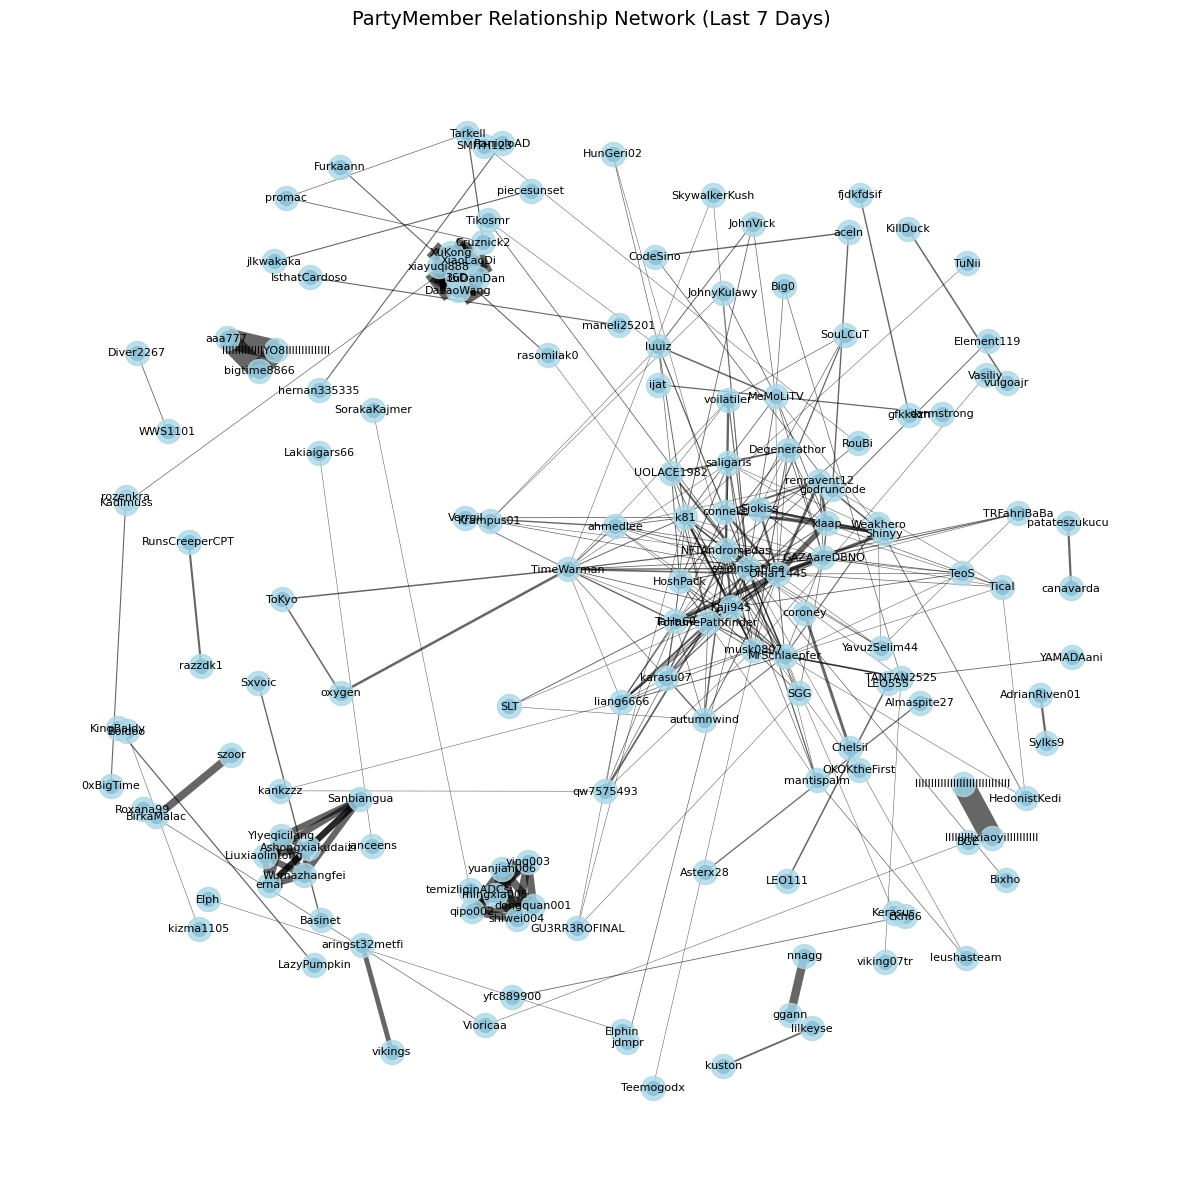

In [ ]:
# create network map
G = nx.Graph()

for _, row in pair_summary_lim.iterrows():
  G.add_edge(row['Member1'], row['Member2'], weight=row['DungeonsCompletedTogether'])

# create graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=1, seed=20)

weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_nodes(G, pos, node_size=100)

# Draw
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=[w*0.1 for w in weights], alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title('PartyMember Relationship Network (Last 7 Days)', fontsize=14)
plt.axis('off')
plt.show()

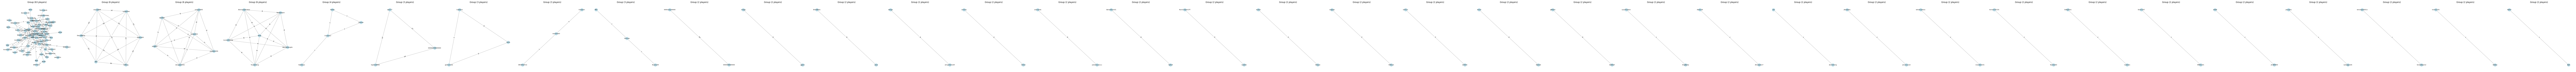

In [ ]:
# Get connected components (each separate group of players)
components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
components = sorted(components, key=len, reverse=True)

# Create one subplot per connected component
n = len(components)
fig, axes = plt.subplots(1, n, figsize=(6*n, 6))
if n == 1:
    axes = [axes]

for ax, subgraph in zip(axes, components):
    # Layout for consistent spacing
    pos = nx.spring_layout(subgraph, k=1.2, seed=42)

    # Draw base network
    nx.draw_networkx_nodes(subgraph, pos, ax=ax, node_size=300, node_color='lightblue', alpha=0.8)
    nx.draw_networkx_edges(subgraph, pos, ax=ax, edge_color='gray', alpha=0.7)
    nx.draw_networkx_labels(subgraph, pos, ax=ax, font_size=8)

    # Add edge labels (number of dungeons completed together)
    edge_labels = nx.get_edge_attributes(subgraph, 'weight')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=7, ax=ax)

    ax.set_title(f'Group ({len(subgraph.nodes)} players)')
    ax.axis('off')

plt.tight_layout()
plt.show()